## **Super Dead Leaves**

Extension of the texture reproduction fidelity chart Dead Leaves using the _superformula_ to generate a variety of random shapes resembling leaves with multiple lobes.
The superformula parameters are randomly sampled in each lobe to generate an organic-looking shape. The final shape is rotated in a random orientation.
The superformula is a generalization of the superellipse that can generate a wide variety of geometric shapes:
- Johan Gielis. "A generic geometric transformation that unifies a wide range of natural and abstract shapes." American journal of botany 90, p. 333-338 (2003)

The superformula in polar coordinates is given by:

\begin{equation}
r(\theta) = \left( \left| \frac{\cos\left(\frac{m \theta}{4}\right)}{a} \right|^{n_2} + \left| \frac{\sin\left(\frac{m \theta}{4}\right)}{b} \right|^{n_3} \right)^{-\frac{1}{n_1}}
\end{equation}

where:
- \(r(\theta)\) defines the radial distance as a function of the polar angle \(\theta\).
- \(m\) determines the number of lobes (periodic symmetry).
- \(n_1\) adjusts the overall roundness or spikiness of the shape (smaller values yield more angular shapes).
- \(n_2\) and \(n_3\) influence the shape's curvature and the sharpness or smoothness of the lobes.
- \(a\) and \(b\) control the scaling along the \(x\) and \(y\) axes (fixed to 1).

The parameters \(n_1, n_2, n_3\) are randomly perturbed in each lobe to generate unique and varied shapes that resemble biological forms.

-------------

**Author**: Andreu Badal (Andreu.Badal-Soler (at) fda.hhs.gov)

**Date**: 2024/09/05

**Disclaimer**
This software and documentation (the "Software") were developed at the US Food and Drug Administration (FDA) by employees of the Federal Government in the course of their official duties. Pursuant to Title 17, Section 105 of the United States Code, this work is not subject to copyright protection and is in the public domain. Permission is hereby granted, free of charge, to any person obtaining a copy of the Software, to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, or sell copies of the Software or derivatives, and to permit persons to whom the Software is furnished to do so. FDA assumes no responsibility whatsoever for use by other parties of the Software, its source code, documentation or compiled executables, and makes no guarantees, expressed or implied, about its quality, reliability, or any other characteristic. Further, use of this code in no way implies endorsement by the FDA or confers any advantage in regulatory decisions. Although this software can be redistributed and/or modified freely, we ask that any derivative works bear some notice that they are derived from it, and any modified versions bear some notice that they have been modified.
       

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from time import time
import random

#%cd /home/abs/SuperDeadLeaves
#%ls -alrth
#%pwd

In [2]:
from SuperDeadLeaves import SuperDeadLeaves

/home/brandon.nelson/Dev/forks/SuperDeadLeaves/src/SuperDeadLeaves/superdeadleaves.py:6: SyntaxWarning: invalid escape sequence '\['
  """


 ** Generating a Superformula shape with seed 54838529, m = 6:


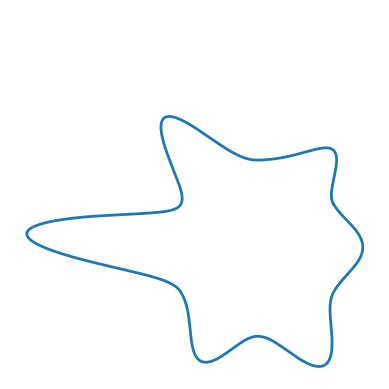

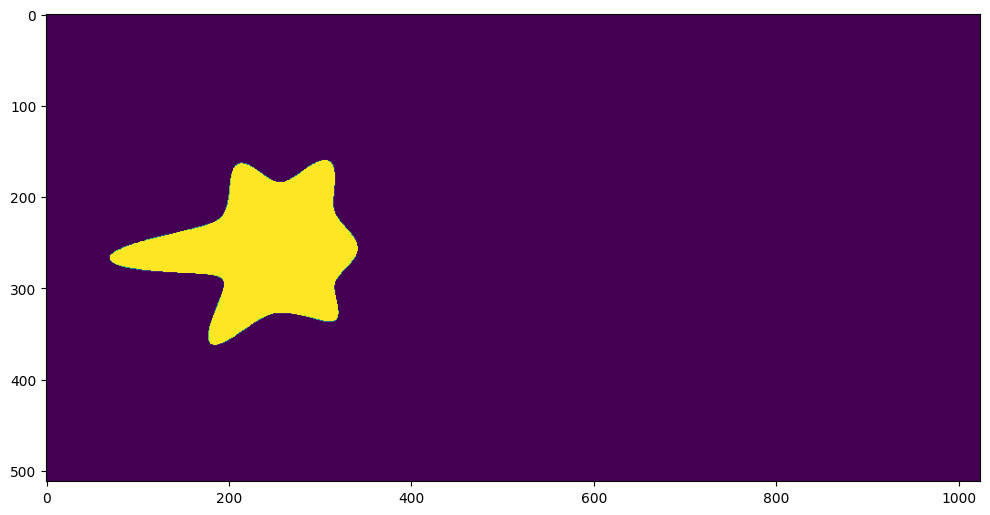

 ** Generating a "Super Dead Leaves" pattern chart:
    - Parameters: image_size = [512, 1024] pixels, seed=54838529, contrast=1.0, num_samples=10000, rmin=0.0075, rmax=0.6666666666666666, rr=500, sigma=3
                  polygon_range=[3, 10], randomized=True, borderFree=True
...Sampled 1000 shapes of 10000 (10.0%)...
...Sampled 2000 shapes of 10000 (20.0%)...
...Sampled 3000 shapes of 10000 (30.0%)...
...Sampled 4000 shapes of 10000 (40.0%)...
...Sampled 5000 shapes of 10000 (50.0%)...
...Sampled 6000 shapes of 10000 (60.0%)...
...Sampled 7000 shapes of 10000 (70.0%)...
...Sampled 8000 shapes of 10000 (80.0%)...
...Sampled 9000 shapes of 10000 (90.0%)...


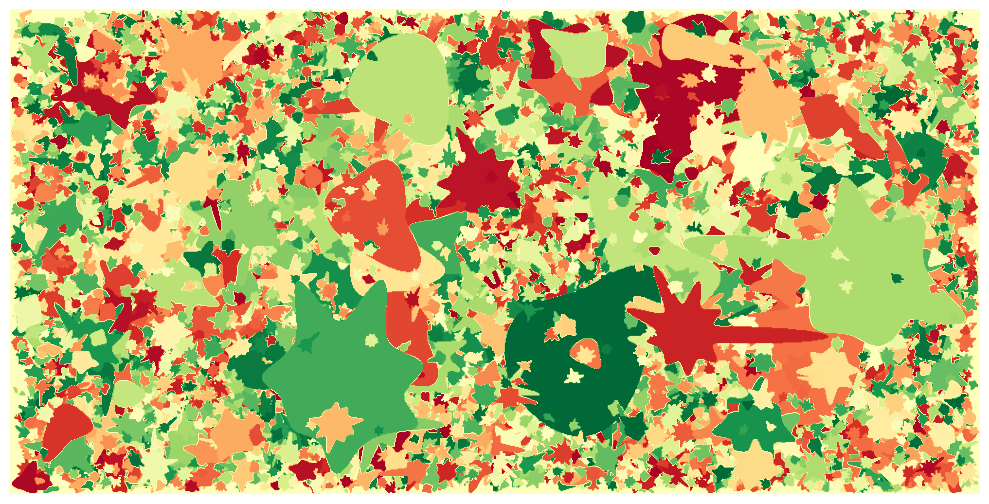

 - Time used to generate the image: 15.5 s
 ** Generating a traditional "Dead Leaves" pattern chart (seed=52896779):
...Sampled 1000 shapes of 10000 (10.0%)...
...Sampled 2000 shapes of 10000 (20.0%)...
...Sampled 3000 shapes of 10000 (30.0%)...
...Sampled 4000 shapes of 10000 (40.0%)...
...Sampled 5000 shapes of 10000 (50.0%)...
...Sampled 6000 shapes of 10000 (60.0%)...
...Sampled 7000 shapes of 10000 (70.0%)...
...Sampled 8000 shapes of 10000 (80.0%)...
...Sampled 9000 shapes of 10000 (90.0%)...


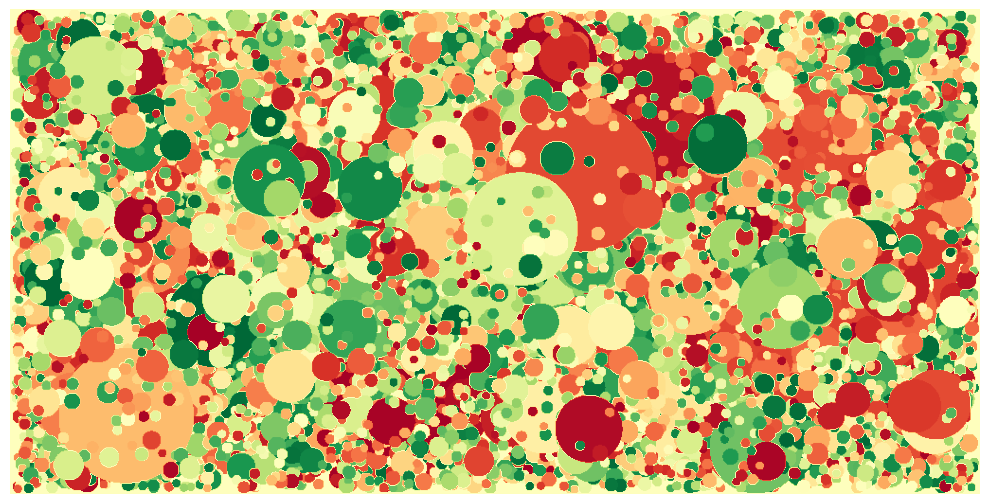

In [3]:
# Example generation of a Super Dead Leaves chart using superformula shapes:
if __name__ == "__main__":

    time0 = time()
    image_size = [512, 1024]  # [1080, 1920] #1024   # [1080, 1920]
    seed = np.random.randint(1, 1e8)

    # - Create a Super Dead Leaves class instance:
    SDL = SuperDeadLeaves(image_size=image_size, seed=seed, polygon_range=[3,10], randomized=True)

    # - Generate a sample shape:
    print(f" ** Generating a Superformula shape with seed {seed}, m = {SDL.m}:")
    X, Y = SDL.generate_polygon()    
    plt.plot(X, Y, linewidth=2)
    plt.axis('square')
    plt.axis('off')
    # plt.savefig('polygon.png')
    plt.show()    

    
    # - Generate a bitmap mask for the sample shape:
    shape_mask = SDL.generate_mask_from_polygon(X, Y)

    plt.figure(figsize=(10, 10))  #figsize=(4, 4), dpi=600)
    plt.imshow(shape_mask, vmin=0, vmax=256)
    #plt.axis('off')
    plt.tight_layout()
    plt.show()

    
    # - Generate a sample SDL chart:
    print(f" ** Generating a \"Super Dead Leaves\" pattern chart:")
    print(f"    - Parameters: image_size = {image_size} pixels, seed={seed}, contrast={SDL.contrast}, num_samples={SDL.num_samples_chart}, rmin={SDL.rmin}, rmax={SDL.rmax}, rr={SDL.rr}, sigma={SDL.sigma}")
    print(f"                  polygon_range={SDL.polygon_range}, randomized={SDL.randomized}, borderFree={SDL.borderFree}")

    chart = SDL.generate_chart()  # (f'SDL_{seed}.tif')
    
    plt.figure(figsize=(10, 10))  #figsize=(4, 4), dpi=600)
    plt.imshow(chart, cmap='RdYlGn', vmin=0, vmax=1)     #  my_cm    , cmap='gray', vmin=0, vmax=1)  'YlGn' 'RdYlGn'
    plt.axis('off')
    plt.tight_layout()
    plt.show()
  
    print(f" - Time used to generate the image: {(time()-time0):.3} s")


    # - Create a traditional Dead Leaves chart with circles:
    seed = np.random.randint(1, 1e8)
    print(f" ** Generating a traditional \"Dead Leaves\" pattern chart (seed={seed}):")
    DL = SuperDeadLeaves(image_size=image_size, seed=seed, polygon_range=[2,2], randomized=False)   # Generate only circles

    chart_DL = DL.generate_chart()  # (f'DL_{seed}.tif')
    
    plt.figure(figsize=(10, 10))  #figsize=(4, 4), dpi=600)
    plt.imshow(chart_DL, cmap='RdYlGn', vmin=0, vmax=1)     #  my_cm    , cmap='gray', vmin=0, vmax=1)  'YlGn' 'RdYlGn'
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    

In [4]:
# Create a GIF animation with chart generation frames:
# Uncomment all the lines above with the comment !!GIF!!
#import imageio
#fps = 3
#imageio.mimsave(f'cell_SDL_{seed}_animation.gif', GIF_frames, fps=fps)
#print(f'Creating GIF animation with {len(GIF_frames)} frames at {fps} fps.')

 ** Generating a cell pattern chart based on the "Super Dead Leaves" algorithm:
    - Parameters: image_size = [512, 1024] pixels, seed=9456447, contrast=1.0, num_samples=150, rmin=0.015, rmax=0.3, rr=500, sigma=3
                  polygon_range=[2, 6], randomized=True, borderFree=True
...Sampled 100 shapes of 150 (27.333333333333332%); 41 added to chart...
...Sampled 200 shapes of 150 (41.333333333333336%); 62 added to chart...


...Sampled 300 shapes of 150 (52.0%); 78 added to chart...
...Sampled 400 shapes of 150 (58.666666666666664%); 88 added to chart...
...Sampled 500 shapes of 150 (62.0%); 93 added to chart...
...Sampled 600 shapes of 150 (64.0%); 96 added to chart...
...Sampled 700 shapes of 150 (66.0%); 99 added to chart...
...Sampled 800 shapes of 150 (68.0%); 102 added to chart...
...Sampled 900 shapes of 150 (70.66666666666667%); 106 added to chart...
...Sampled 1000 shapes of 150 (71.33333333333333%); 107 added to chart...
...Sampled 1100 shapes of 150 (72.66666666666667%); 109 added to chart...
...Sampled 1200 shapes of 150 (76.0%); 114 added to chart...
...Sampled 1300 shapes of 150 (76.66666666666667%); 115 added to chart...
...Sampled 1400 shapes of 150 (77.33333333333333%); 116 added to chart...
...Sampled 1500 shapes of 150 (80.0%); 120 added to chart...

  - Number of cells included in the chart: 120



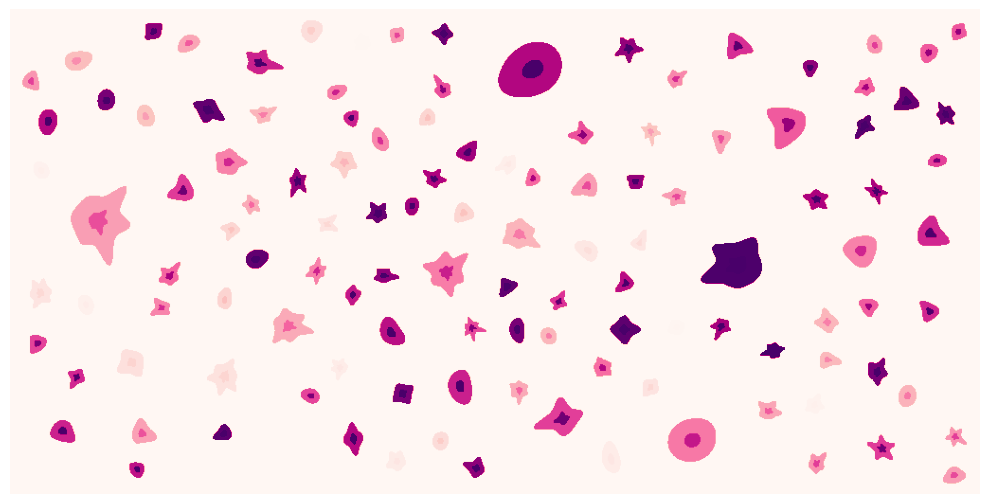

In [5]:
# Extension of SDL to generate a random cell chart:

#image_size = 1024   # [1080, 1920]
seed = np.random.randint(1, 1e8)  # 38717094

# - Create a Super Dead Leaves class instance:
SDL = SuperDeadLeaves(image_size=image_size, seed=seed, polygon_range=[2,6], randomized=True, borderFree=True)

# - Generate a sample cell SDL chart:

SDL.num_samples_chart = 150
#SDL.contrast = 0.5
SDL.rmin = 0.015
SDL.rmax = 0.300
SDL.variability_n1 = 0.2
SDL.background_color = 0.0

print(f" ** Generating a cell pattern chart based on the \"Super Dead Leaves\" algorithm:")
print(f"    - Parameters: image_size = {image_size} pixels, seed={seed}, contrast={SDL.contrast}, num_samples={SDL.num_samples_chart}, rmin={SDL.rmin}, rmax={SDL.rmax}, rr={SDL.rr}, sigma={SDL.sigma}")
print(f"                  polygon_range={SDL.polygon_range}, randomized={SDL.randomized}, borderFree={SDL.borderFree}")

fname = None #f'cell_SDL_{seed}.tif'  # None
cell_chart = SDL.generate_cell_chart(cell_spacing_area_factor=4.0, cell_nucleus_area_factor=0.10, cell_nucleus_intensity=1.5, filename=fname)  # !!CELL!!)  # (f'cellSDL_{seed}.tif')

plt.figure(figsize=(10, 10))  #figsize=(4, 4), dpi=600)
plt.imshow(cell_chart, cmap='RdPu', vmin=0, vmax=1)     #  RdPu    , cmap='gray', vmin=0, vmax=1)  'YlGn' 'RdYlGn'
plt.axis('off')
plt.tight_layout()
plt.show()      